### Set-up

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import yaml
import os
import sys
import random
sys.path.append("../seg_anything/")
sys.path.append("..")
import argparse
import onnxruntime
from PIL import Image
from semseg.utils.visualize import generate_palette
from semseg.utils.utils import timer
from infer_make_label import SemSeg
from seg_anything.segment_anything import sam_model_registry, SamPredictor
from visualization import *
device = "cuda"

### Initialize SAM model

In [2]:
# path to the sam model
sam_checkpoint = "../seg_anything/sam_vit_h_4b8939.pth" 
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

### 1: Use SAM to directly generate pseudo labels
Segment anything model takses input points as cues to generate segmentation mask

Since in the collected data, the region in front of the road most be drivable in must cases. Therefore, it is possible for us to select the points on the bottom of the image as input points for SAM to automatically generate labels

#### Example 

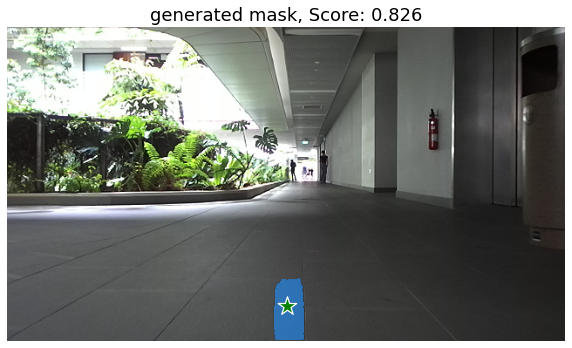

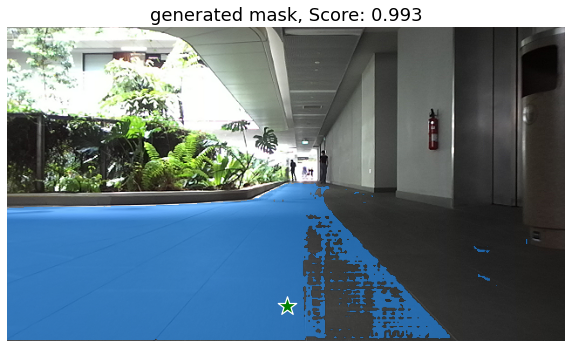

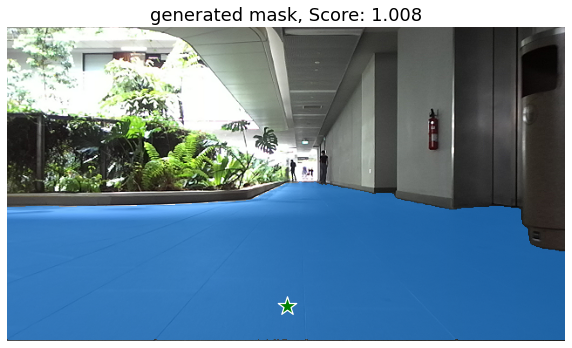

In [3]:
# first generate some road_mask proposals
image_path = '../docs/test_image.png'
image = cv2.imread(image_path)[:,:,:3]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

# [320,320] is chose as the mid bottom point in the image, which is usually drivable
input_point = np.array([[320, 320]])           
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"generated mask, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

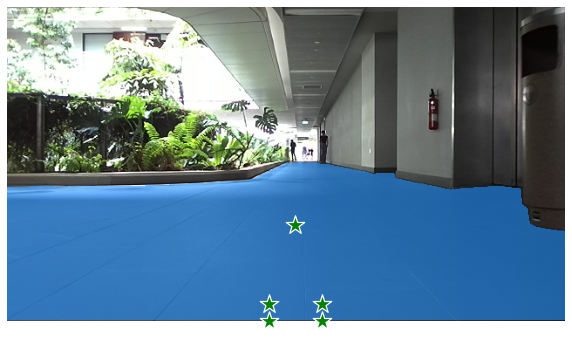

In [4]:
# use the generated mask with the largest region for further road extraction and you can also try to use the best mask
# with the highest score

input_point = np.array([[360,340], [330, 250],[300,340],[300,360],[360,360]])   #here some points belong to the road are selected
input_label = np.ones(shape=input_point.shape[0])

foreground_counts = np.sum(logits, axis=(1, 2))       # Choose the model's largest mask
mask_input = logits[np.argmax(foreground_counts)]
# mask_input = logits[np.argmax(scores), :, :]        # Choose the model's best mask
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca(),False)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

#### Generate the mask and save the label

In [8]:
"""
def a data generation function:
Args:
    image_path: input the image dir
    save_path:  the label saving dir
    mode: 0: save the visualization results 1: save the training label 
    the label is save in a png, you can also modify the code to the format you need 
"""

def make_label(image_path,save_path,mode=0):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    input_point = np.array([[320,200]])                        # The inital input point
    input_label = np.array([1])
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    foreground_counts = np.sum(logits, axis=(1, 2))            # Choose the model's largest mask
    mask_input = logits[np.argmax(foreground_counts)]
    
    # mask_input = logits[np.argmax(scores), :, :]             # Choose the model's best mask
    
    input_point = np.array([[280,340], [360, 340],[320,280]])  # The final input point
    input_label = np.array([1,1,1])
    
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    
    if mode==1:
        masks = np.array(masks)
        masks = np.transpose(masks,[1,2,0])
        masks = np.concatenate((masks, masks, masks), axis=2)
        masks = np.uint8(masks)
        cv2.imwrite(save_path,masks)
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(masks, plt.gca(),False)
        show_points(input_point, input_label, plt.gca())
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=100)
        plt.close()


In [9]:
"""
generate labels using sam, an example

Note: better implment in .py not this .ipynb file, which may lead to some memory error
"""
image_dir  = '../data/ntu/images'
save_dir   = '../data/ntu/labels/1'
os.makedirs(save_dir,exist_ok=True)
image_list = os.listdir(image_dir)
for image_name in image_list:
    print(image_name)
    image_path = os.path.join(image_dir,image_name)
    save_path  = os.path.join(save_dir,image_name)
    make_label(image_path,save_path,0)

26_new.png
57_new.png
86_new.png
44_new.png
20_new.png
63_new.png
69_new.png
39_new.png
76_new.png
36_new.png
90_new.png
56_new.png
51_new.png
15_new.png
73_new.png
42_new.png
30_new.png
77_new.png
10_new.png
53_new.png
84_new.png
72_new.png
16_new.png
21_new.png
35_new.png
8_new.png
60_new.png
23_new.png
79_new.png
0_new.png
22_new.png
75_new.png
88_new.png
31_new.png
65_new.png
89_new.png
1_new.png
17_new.png
58_new.png
68_new.png
28_new.png
67_new.png
55_new.png
11_new.png
2_new.png
5_new.png
94_new.png
83_new.png
54_new.png
43_new.png
81_new.png
6_new.png
4_new.png
7_new.png
3_new.png
14_new.png
61_new.png
59_new.png
48_new.png
34_new.png
62_new.png
91_new.png
50_new.png
12_new.png
49_new.png
80_new.png
71_new.png
38_new.png
32_new.png
52_new.png
37_new.png
46_new.png
13_new.png
29_new.png
70_new.png
78_new.png
24_new.png
19_new.png
100_new.png
87_new.png
85_new.png
27_new.png
74_new.png
47_new.png
18_new.png
25_new.png
9_new.png
64_new.png
92_new.png
41_new.png
99_new.png
93_new.p

### 2: Use a pretrained model and SAM to generate pseudo labels
Some of the gererated labels may not have a good quality using the first method due to: complex features of the road, inapproporiate input points, motion blue,robot movement, etc. 
To tackle the problem, there are some possible ways:
1. Delete the bad quality labels using the visualization results and use lebeling tools like labelme for data labeling. Note: The latest version of labelme also support weakly supervised data labeling with UI interface, it is also a good choice to use labelme to generate the mask.
2. Generate more reasonable input points. Suppose we already have a road segmentation model (maybe with domain gap, e.g. pretrained on public dataset or model train with few samples), we can use it to generate the input points which are more reasonable. And this mode can be adopted to semi-supervised learning or domain adaptation tasks.

Note: It can support multiclass label generation, however, in this notebook, only single class label generation process is implemented as it is only for road segmentation

In [5]:
"""
This function aims to random select input points from the prediction of a pretrained model
Args:
    num_points: select how many points
Note: this function simply randamly selected n points, it can also be modified to selelect n points with the highest confidence
"""
def select_random_foreground_points(segmap, num_points=10):
    foreground_indices = np.where(segmap == 1)                   # CAN BE MODIFIED TO MULTICLASS LABEL GENERATION
    if len(foreground_indices[0])==0:
        selected_points =  np.array([[280,340], [360, 340],[320,280]])  # The final input point
        ones_array = np.array([1,1,1])
    else:
        num_foreground_points = len(foreground_indices[0])
        if num_points >= num_foreground_points:
            # If num_points is greater than or equal to the number of foreground points, select all points
            selected_points_indices = range(num_foreground_points)
        else:
            # Otherwise, randomly sample the specified number of points
            selected_points_indices = random.sample(range(num_foreground_points), num_points)
        selected_points = np.array([(foreground_indices[1][idx], foreground_indices[0][idx]) for idx in selected_points_indices])
        ones_array = np.ones(num_points, dtype=int)

    return selected_points, ones_array


#### Example

/home/kemove/anaconda3/envs/il/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


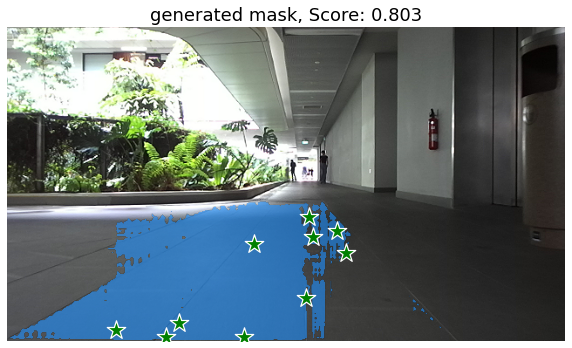

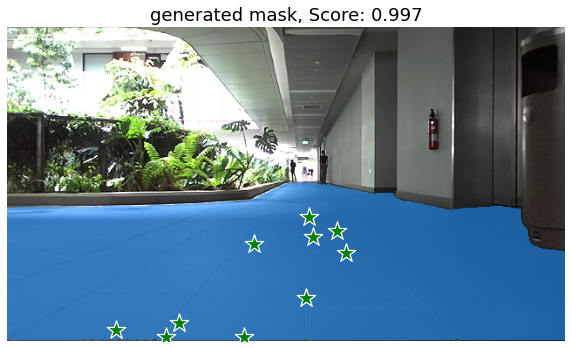

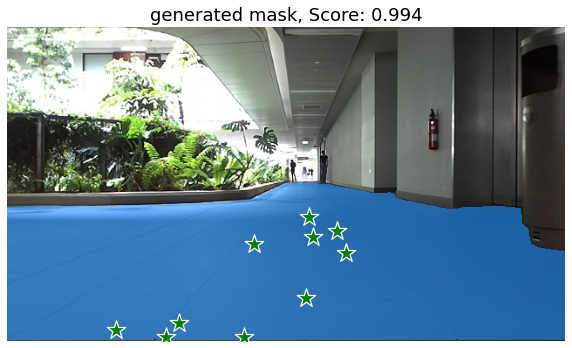

In [6]:
# first generate some road_mask proposals
image_path = '../docs/test_image.png'
image = cv2.imread(image_path)[:,:,:3]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

config = '../configs/custom.yaml'                        #this is the road segmentation model train on bdd100k dataset
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)
semseg = SemSeg(cfg)                                  # Define the model here
segmap = semseg.predict(image_path, cfg['TEST']['OVERLAY'])
segmap = segmap.numpy()

input_point,input_label = select_random_foreground_points(segmap)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"generated mask, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

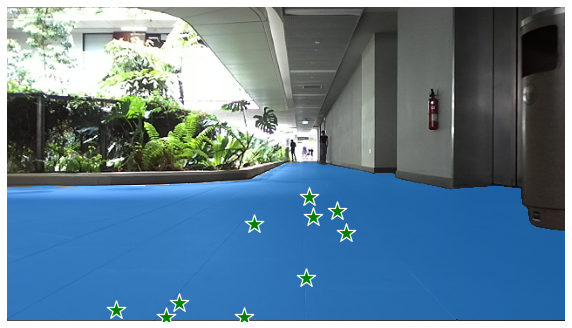

In [7]:
foreground_counts = np.sum(logits, axis=(1, 2))       # Choose the model's largest mask
mask_input = logits[np.argmax(foreground_counts)]
# mask_input = logits[np.argmax(scores), :, :]        # Choose the model's best mask
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca(),False)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

#### Generaet labels

In [144]:
"""
def a data generation function:
Args:
    image_path: input the image dir
    save_path:  the label saving dir
    mode: 0: save the visualization results 1: save the training label 
    the label is save in a png, you can also modify the code to the format you need 

In this function, the number of randomly selected point can be different
"""

def make_label2(image_path,save_path,model,mode=1):
    segmap = model.predict(str(image_path), 'false')
    segmap = segmap.numpy()
    input_point,input_label = select_random_foreground_points(segmap,5)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    # foreground_counts = np.sum(logits, axis=(1, 2))            # Choose the model's largest mask
    # mask_input = logits[np.argmax(foreground_counts)]
    
    mask_input = logits[np.argmax(scores), :, :]             # Choose the model's best mask
    input_point,input_label = select_random_foreground_points(segmap,10)
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    
    if mode==1:
        masks = np.array(masks)
        masks = np.transpose(masks,[1,2,0])
        masks = np.concatenate((masks, masks, masks), axis=2)
        masks = np.uint8(masks)
        cv2.imwrite(save_path,masks)
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(masks, plt.gca(),False)
        show_points(input_point, input_label, plt.gca())
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=100)
        plt.close()
        # plt.show()


In [14]:
"""
generate labels using sam and pretrain_data
"""
config = '../configs/custom.yaml'                        #this is the road segmentation model train on bdd100k dataset
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)
semseg = SemSeg(cfg)

image_dir  = '../data/ntu/images'
save_dir   = '../data/ntu/labels/2'
os.makedirs(save_dir,exist_ok=True)
image_list = os.listdir(image_dir)
for image_name in image_list:
    print(image_name)
    image_path = os.path.join(image_dir,image_name)
    save_path  = os.path.join(save_dir,image_name)
    make_label2(image_path,save_path,semseg,0)

26_new.png
57_new.png
86_new.png
44_new.png
20_new.png
63_new.png
69_new.png
39_new.png
76_new.png
36_new.png
90_new.png
56_new.png
51_new.png
15_new.png
73_new.png
42_new.png
30_new.png
77_new.png
10_new.png
53_new.png
84_new.png
72_new.png
16_new.png
21_new.png
35_new.png
8_new.png
60_new.png
23_new.png
79_new.png
0_new.png
22_new.png
75_new.png
88_new.png
31_new.png
65_new.png
89_new.png
1_new.png
17_new.png
58_new.png
68_new.png
28_new.png
67_new.png
55_new.png
11_new.png
2_new.png
5_new.png
94_new.png
83_new.png
54_new.png
43_new.png
81_new.png
6_new.png
4_new.png
7_new.png
3_new.png
14_new.png
61_new.png
59_new.png
48_new.png
34_new.png
62_new.png
91_new.png
50_new.png
12_new.png
49_new.png
80_new.png
71_new.png
38_new.png
32_new.png
52_new.png
37_new.png
46_new.png
13_new.png
29_new.png
70_new.png
78_new.png
24_new.png
19_new.png
100_new.png
87_new.png
85_new.png
27_new.png
74_new.png
47_new.png
18_new.png
25_new.png
9_new.png
64_new.png
92_new.png
41_new.png
99_new.png
93_new.p

### 3: Use Depthanything model and SAM to generate pseudo labels
Depthanything model is able to provide the relative depth map for the input rgb image. With the depth map, we can transform the image into 3D space (pointcloud) and use traditional method to extract the potential road points. These road points can be used as the ref points and input to SAM for unsupervised road segmentation.

Here, we use depthanythingv2 to obtain relative depth map and RANSAC to extract potential road points from the pointcloud.

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import yaml
import os
import sys
import random
sys.path.append("../seg_anything/")
sys.path.append("..")
import argparse
import onnxruntime
from PIL import Image
from semseg.utils.visualize import generate_palette
from semseg.utils.utils import timer
from infer_make_label import SemSeg
from seg_anything.segment_anything import sam_model_registry, SamPredictor
from visualization import *
from utlis.pc_infer_fusion import *
from utlis.sam_infer_fusion import *
from depth_anything_v2.dpt import DepthAnythingV2

In [6]:
device = "cuda"
model = DepthAnythingV2(encoder='vitl', features=256, out_channels=[256, 512, 1024, 1024]).to(device)
model.load_state_dict(torch.load('../depth_anything_v2/depth_anything_v2_vitl.pth'))
model.eval()
from segment_anything import sam_model_registry, SamPredictor
sam_checkpoint = "../seg_anything/sam_vit_h_4b8939.pth" 
model_type = "vit_h"
opt=None
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)


In [41]:
def fustion_info2(mean_mask,mask_depth_normalized,image_raw):

    a = mean_mask.copy()
    valid = np.array([d for d in a.flatten() if d != 0])
    # a[a!=0]=1
    a[a>=0.1]=1
    a[a!=1]=0

    b = mask_depth_normalized.copy()
    valid = np.array([d for d in b.flatten() if d != 0])
    b[b>=0.1]=1
    b[b!=1]=0

    c = a*b
    c = 1-c
    d = ((0.8*mean_mask[0]+0.1*mask_depth_normalized)*c)
    t = distance_distribution(d.flatten())
    d[d>=t]=1
    d[d!=1]=0
    f = (1-c)+d
    return f

In [46]:
file_name = '../data/hdb/images/train/image_10.png'
image_raw = cv2.imread(file_name)
image_raw = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB)
image_raw = cv2.resize(image_raw,(640,360))
h, w = image_raw.shape[:2]
print(f"The height is {h}, the width is {w}")

The height is 360, the width is 640


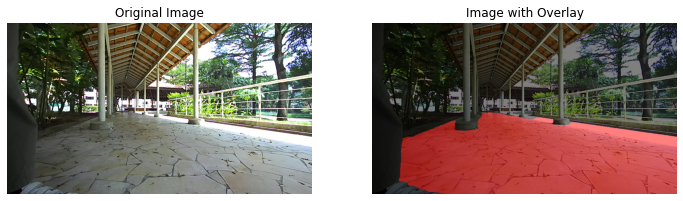

In [47]:
depth = model.infer_image(image_raw,device)
depth[depth<=10]=10
mask_depth,distance,points_to_mark = road_init_with_fit(depth,vis=0,fit=1,normal_threshold=0.3,upper_fit_thred=30,lower_fit_thred=-30,focal_length=200,distance_thred_depth=0.6)
mask_depth_normalized = (mask_depth - mask_depth.min()) / (mask_depth.max() - mask_depth.min())
mask_depth_normalized = 1 - mask_depth_normalized
final_mask,mean_mask = sam_predict(image_raw,points_to_mark,predictor,device=device,opt=opt,use_robust=0,num_groups=30,use_mean=0,p=0.1)
final_mask = fustion_info2(mean_mask,mask_depth_normalized,image_raw)
final_mask = CRFlayer(image_raw,final_mask,depth,image_rgb=3,image_xy=3,depth_xy=3,depth_rgb=3)
vis_mask(image_raw,final_mask)

In [10]:
def save_mask(image_raw, mask, vis_save_path, mask_save_path):
    colored_mask = np.zeros_like(image_raw)
    colored_mask[..., 0] = mask * 255  # Red channel
    colored_mask[..., 1] = mask * 0    # Green channel
    colored_mask[..., 2] = mask * 0    # Blue channel

    # Overlay the mask on the image using alpha blending
    alpha = 0.5
    overlay_image = image_raw.copy()
    overlay_image = (overlay_image * (1 - alpha) + colored_mask * alpha).astype(np.uint8)

    plt.imsave(vis_save_path, overlay_image)
    plt.imsave(mask_save_path, mask, cmap='gray')

In [37]:
import glob

split = '/train' # selected from train/val

input_dir = '/media/kemove/boot/home/amov/bag/hdb_images/images_new'
mask_dir = '/media/kemove/boot/home/amov/bag/hdb_images/labels'
vis_dir    = '/media/kemove/boot/home/amov/bag/hdb_images/vis'

if not os.path.exists(vis_dir):
    os.makedirs(vis_dir)
if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

for filename in os.listdir(input_dir):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        file_path = os.path.join(input_dir, filename)
        print(file_path)
        image_raw = cv2.imread(file_path)
        image_raw = cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB)
        image_raw = cv2.resize(image_raw, (640, 360))
        depth = model.infer_image(image_raw,device)
        depth[depth<=10]=10
        mask_depth,distance,points_to_mark = road_init_with_fit(depth,vis=0,fit=1,normal_threshold=0.3,upper_fit_thred=30,lower_fit_thred=-30,focal_length=200,distance_thred_depth=0.6)
        mask_depth_normalized = (mask_depth - mask_depth.min()) / (mask_depth.max() - mask_depth.min())
        mask_depth_normalized = 1 - mask_depth_normalized
        final_mask,mean_mask = sam_predict(image_raw,points_to_mark,predictor,device=device,opt=opt,use_robust=0,num_groups=50,use_mean=0,p=0.1)
        final_mask = fustion_info2(mean_mask,mask_depth_normalized,image_raw)
        f_mask = CRFlayer(image_raw,final_mask,depth,image_rgb=6,image_xy=6,depth_xy=5,depth_rgb=5)
        vis_save_path = os.path.join(vis_dir, filename)
        mask_save_path = os.path.join(mask_dir, filename)

        save_mask(image_raw, f_mask, vis_save_path, mask_save_path)


/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_195.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_895.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_753.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_883.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_249.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_1259.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_688.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_19.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_1059.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_656.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_166.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_972.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor2_1178.png
/media/kemove/boot/home/amov/bag/hdb_images/images_new/outdoor

In [1]:
# import cv2
# import os

# split = '/train'
# old_dir = '/home/kemove/delta_project/Sementic_segmentation/semantic-segmentation/data/ntu/labels'+split
# new_dir = '/media/kemove/boot/home/amov/bag/hdb2/labels'+split

# for image_name in os.listdir(old_dir):
#     image_path = os.path.join(old_dir,image_name)
#     image = cv2.imread(image_path)*255
#     cv2.imwrite(os.path.join(new_dir,image_name),image)
